In [12]:
from google.colab import drive
drive.mount('/content/drive')

# 현재 노트북 파일 저장
!cp /content/your_notebook.ipynb /content/drive/MyDrive/your_notebook.ipynb

Mounted at /content/drive
cp: cannot stat '/content/your_notebook.ipynb': No such file or directory


In [ ]:
!git rebase -i HEAD~2

hint: Waiting for your editor to close the file... 7[>4;2m="/content/COSE474_Project/.git/rebase-merge/git-rebase-todo" 30L, 1322B▽  Pzz\[0%m           [>c]10;?]11;?pick c2e2620 try clip
pick 4f2f933 try clip# Rebase 449ad02..4f2f933 onto 449ad02 (2 commands)
#
# Commands:
# p, pick <commit> = use commit
# r, reword <commit> = use commit, but edit the commit message
# e, edit <commit> = use commit, but stop for amending
# s, squash <commit> = use commit, but meld into previous commit
# f, fixup [-C | -c] <commit> = like "squash" but keep only the previous
#                    commit's log message, unless -C is used, in which case
#                    keep only this commit's message; -c is same as -C but
#                    opens the editor
# x, exec <command> = run command (the rest of the line) using shell
# b, break = stop here (continue rebase later with 'git rebase --continue')
# d, drop <commit> = remove commit
# l, label <label> = label current HEAD with a name
# t, r

In [25]:
!git log

commit 4f2f933984798874534fa1c14f2a9ba9583845cf (HEAD -> main)
Author: koheon2 <gykoh0522@korea.ac.kr>
Date:   Mon Nov 25 12:06:21 2024 +0000

    try clip

commit c2e2620f9607f4da4923047ff409e8317a8baf1a
Author: koheon2 <gykoh0522@korea.ac.kr>
Date:   Mon Nov 25 12:02:11 2024 +0000

    try clip

commit 449ad02327970c7170508ffeafd716b2578c1add (origin/main, origin/HEAD)
Author: Koh Geonyeong <121935486+koheon2@users.noreply.github.com>
Date:   Mon Nov 25 20:25:30 2024 +0900

    Update README.md

commit 063c2d32567c66af3719cc4b8fcc803e9cf6346b
Author: Koh Geonyeong <121935486+koheon2@users.noreply.github.com>
Date:   Mon Nov 25 20:25:02 2024 +0900

    Initial commit


In [23]:
!git config --global user.name "koheon2"
!git config --global user.email "gykoh0522@korea.ac.kr"

!cp "/content/drive/MyDrive/Colab Notebooks/COSE474_Final_Project.ipynb" /content/COSE474_Project

!git add COSE474_Final_Project.ipynb
!git commit -m "try clip"

!git push https://{os.environ['GITHUB_TOKEN']}@github.com/koheon2/COSE474_Project.git

[main 4f2f933] try clip
 1 file changed, 1 insertion(+), 1 deletion(-)
 rewrite COSE474_Final_Project.ipynb (86%)
Enumerating objects: 7, done.
Counting objects: 100% (7/7), done.
Delta compression using up to 2 threads
Compressing objects: 100% (6/6), done.
Writing objects: 100% (6/6), 714.01 KiB | 10.20 MiB/s, done.
Total 6 (delta 1), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (1/1), done.
remote: error: GH013: Repository rule violations found for refs/heads/main.
remote: 
remote: - GITHUB PUSH PROTECTION
remote:   —————————————————————————————————————————
remote:     Resolve the following violations before pushing again
remote: 
remote:     - Push cannot contain secrets
remote: 
remote:     
remote:      (?) Learn how to resolve a blocked push
remote:      https://docs.github.com/code-security/secret-scanning/working-with-secret-scanning-and-push-protection/working-with-push-protection-from-the-command-line#resolving-a-blocked-push
remote:     
remote:     
rem

In [ ]:
!pip install transformers

In [ ]:
from PIL import Image
import requests
import torch
from transformers import CLIPProcessor , CLIPModel

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


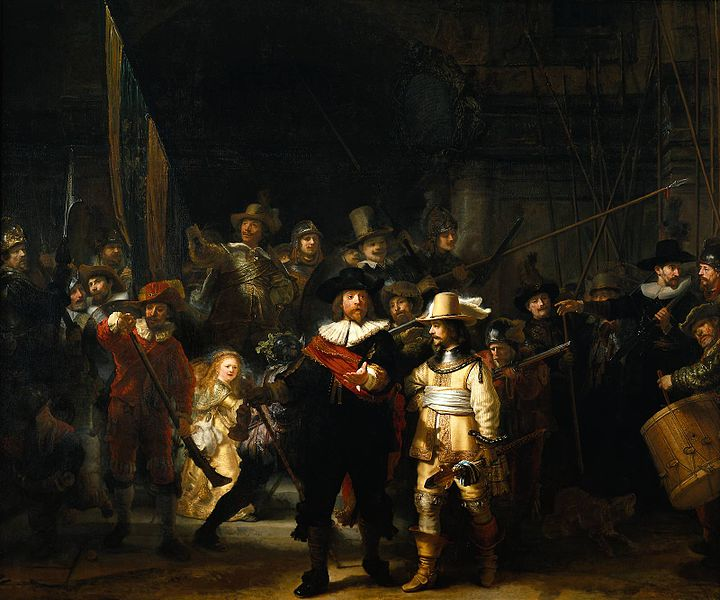

In [ ]:
url = "https://postfiles.pstatic.net/20121104_160/altazor1_1352027235993OBz4a_JPEG/The_Nightwatch_by_Rembrandt.jpg?type=w2"
image = Image.open(requests.get(url, stream=True).raw)
image

In [ ]:
text_query = ["a photo of a paint of Renaissance","a photo of paint of Baroque" ,"a photo of paint of popart"]

In [ ]:
inputs = processor(text=text_query, images=image, return_tensors="pt", padding=True)

outputs = model(**inputs)
logits_per_image = outputs.logits_per_image
probs = logits_per_image.softmax(dim=1)

pred_idx = torch.argmax(probs[0]).item()
pred_text = text_query[pred_idx]

print(f'pred: {pred_text}')

pred: a photo of paint of Baroque
